In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import os

In [60]:
DATA_DIR = "../OFC_data/"
IMG_DIR = "./images/EC125"
os.makedirs(IMG_DIR, exist_ok=True)
fn = "v7_EC125_TimeAveragedSpectraPower_6mA_FreqBands.pkl"
patient = fn.split("_")[1]
current = [i for i in fn.split("_") if "mA" in i][0]
savefig = False

In [61]:
patient, current

('EC125', '6mA')

In [41]:
with open(f"{DATA_DIR}/{fn}", "rb") as f:
    data_dict = np.load(f, allow_pickle=True).item()

In [42]:
dataset_keys = [name for name in data_dict.keys()]
print("\n".join(dataset_keys))

Fs
dsFs
finalVerifiedChanNames
finalVerifiedRegions
freqs
meanAfterStim
meanBeforeStim
meanDuringStim
numVerifiedChans
power_stim
regionNames
stimEndSample
stimStartSample


In [74]:
power = data_dict["power_stim"]
freqs = data_dict["freqs"]

print(power.shape)
cutoff_freq = 32
cutoff_idx = np.where(freqs > cutoff_freq)[0][0]
power = power[:, :cutoff_idx]
print(cutoff_idx)
freqs = freqs[:cutoff_idx]
print(power.shape)

(17, 31, 224964)
21
(17, 21, 224964)


In [44]:
Fs = data_dict["Fs"]
dsFs = data_dict["dsFs"]
stim_start = int(np.floor(int(1.0 * data_dict["stimStartSample"]) * dsFs / Fs))
stim_end = int(np.floor(int(1.0 * data_dict["stimEndSample"]) * dsFs / Fs))

stim_start = int(1.0 * data_dict["stimStartSample"])
stim_end = int(1.0 * data_dict["stimEndSample"])

print(stim_start, stim_end)
print(stim_start * dsFs / Fs, stim_end * dsFs / Fs)

12972 131088
810.75 8193.0


In [45]:
finalVerifiedChanNames = data_dict["finalVerifiedChanNames"]
finalVerifiedRegions = data_dict["finalVerifiedRegions"]
regionNames = data_dict["regionNames"]

In [46]:
print(len(freqs))
print(freqs)
print(len(finalVerifiedChanNames))
print(finalVerifiedChanNames)
print(finalVerifiedRegions)
print(regionNames)

26
[ 4.07492865  4.499086    4.96739367  5.48444726  6.05532071  6.6856161
  7.38151862  8.14985731  8.99817199  9.93478734 10.96889452 12.11064142
 13.37123219 14.76303725 16.29971462 17.99634398 19.86957468 21.93778904
 24.22128283 26.74246438 29.5260745  32.59942923 35.99268797 39.73914935
 43.87557808 48.44256567]
17
['AOF1' 'AOF4' 'POF2' 'AD2' 'AD3' 'AD4' 'HD2' 'HD3' 'SC3' 'SC4' 'IC2'
 'IC3' 'IND1' 'IND2' 'IND3' 'IND4' 'IND5']
[1 1 1 2 2 2 3 3 4 4 5 5 6 6 6 6 6]
['OFC' 'Amygdala' 'Hippocampus' 'SuperiorCingulate' 'InferiorCingulate'
 'Insula']


Power

In [47]:
power.shape

(17, 26, 224964)

In [48]:
plt_data = power[0]
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

total_zscore = (plt_data - np.mean(plt_data[:, :], axis=1, keepdims=True)) / np.std(
    plt_data[:, :], axis=1, keepdims=True
)

In [49]:
print(
    "difference between mean before stimulation and mean of entire time series: ",
    np.mean(
        np.abs(
            np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
            - np.mean(plt_data[:, :], axis=1, keepdims=True)
        )
    ),
)
print(
    "difference between std before stimulation and std of entire time series: ",
    np.mean(
        np.abs(
            np.std(plt_data[:, :stim_start], axis=1, keepdims=True)
            - np.std(plt_data[:, :], axis=1, keepdims=True)
        )
    ),
)

difference between mean before stimulation and mean of entire time series:  0.09583942872413011
difference between std before stimulation and std of entire time series:  0.0891226563108244


In [50]:
np.floor((stim_start / Fs) * dsFs)

810.0

In [71]:
dsFs

array(512, dtype=uint16)

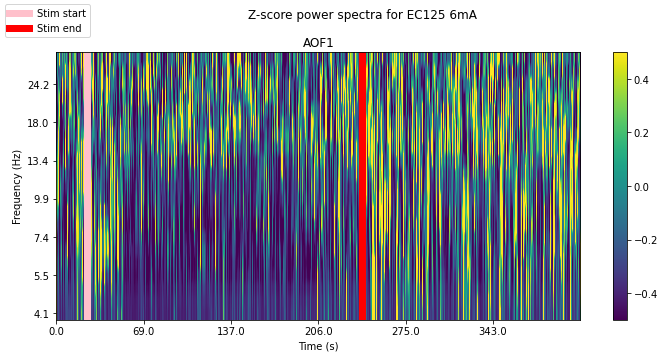

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
# plt_data = np.mean(power[0:5], axis=0) # average over electrodes in OFC
plt_data = power[1]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / Fs * 15 for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = True
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

In [212]:
np.mean(plt_data, axis=1), np.std(plt_data, axis=1)

(array([ 4.48034352e-15, -3.04403394e-15,  9.60123722e-15, -4.03231480e-15,
        -5.06535134e-15,  8.53221600e-15,  7.22844470e-15, -1.56468140e-15,
         1.76131422e-14, -9.06253275e-16,  1.07161193e-14, -2.23127566e-15,
        -6.18090774e-15,  7.31534688e-15,  1.89188692e-14, -3.31471780e-15,
         2.21657396e-15, -6.68515994e-16, -3.55368377e-14,  4.65863387e-15,
        -4.29728694e-15]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]))

In [213]:
fig, axes = plt.subplots(5, 4, sharey=True, sharex=True, figsize=(20, 20))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        plt_data = power[i * len(axes[i]) + j]
        v = np.max(np.abs(plt_data))
        im = ax.imshow(
            plt_data, aspect="auto", cmap="Greys"
        )  # plot lower frequency at bottom
        ax.axvline(stim_start, color="blue")
        ax.axvline(stim_end, color="blue")
        fig.colorbar(im, ax=ax)
        ax.invert_yaxis()
        steps = 6
        chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (steps)]
        ax.set_yticks(chosen_indices)
        ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices]))
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title(f"{finalVerifiedChanNames[i*len(axes[i]) + j]}")
fig.suptitle("EC 105 1mA Spectra")
fig.tight_layout()

IndexError: index 17 is out of bounds for axis 0 with size 17

Error in callback <function flush_figures at 0x7f89049b7680> (for post_execute):


KeyboardInterrupt: 

Log power

Text(0.5, 1.0, 'AOF1')

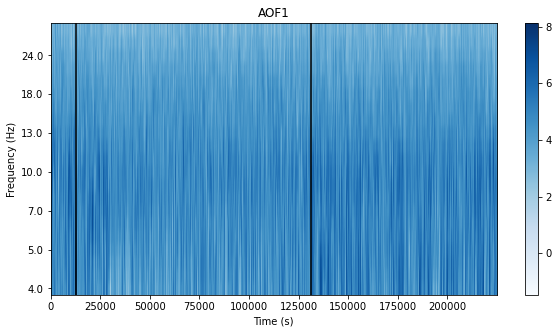

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt_data = np.log(np.mean(power[:3], axis=0))
im = ax.imshow(plt_data, aspect="auto", cmap="Blues")  # plot lower frequency at bottom
ax.axvline(stim_start, color="black")
ax.axvline(stim_end, color="black")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"{finalVerifiedChanNames[0]}")

IndexError: index 18 is out of bounds for axis 0 with size 18

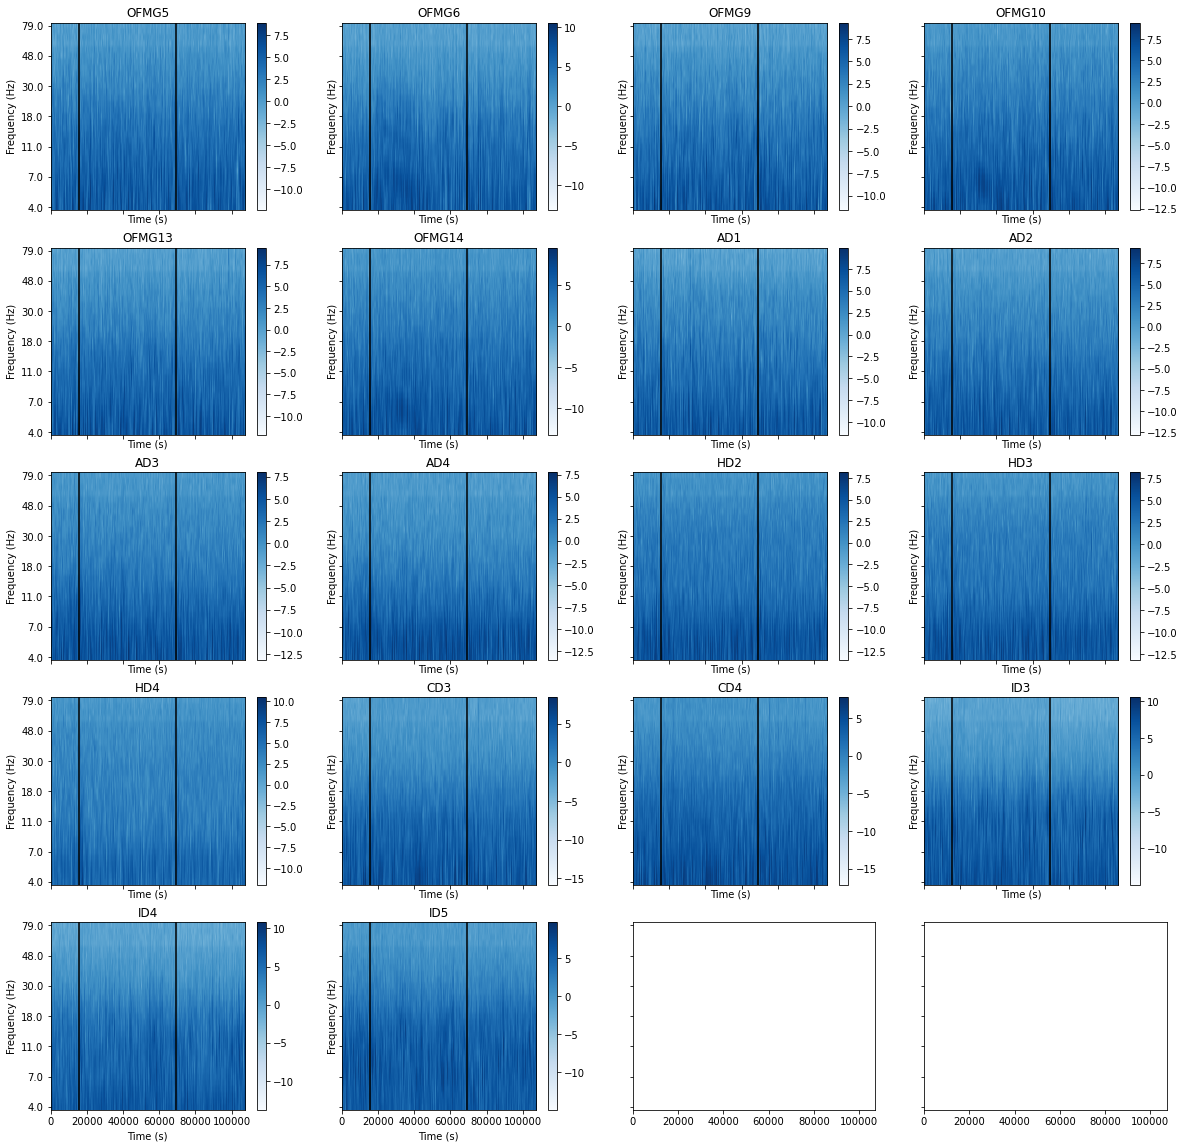

In [ ]:
fig, axes = plt.subplots(5, 4, sharey=True, sharex=True, figsize=(20, 20))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        plt_data = np.log(power[i * len(axes[i]) + j])
        im = ax.imshow(plt_data, aspect="auto", cmap="Blues")
        ax.axvline(stim_start, color="black")
        ax.axvline(stim_end, color="black")
        fig.colorbar(im, ax=ax)
        ax.invert_yaxis()
        steps = 6
        chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (steps)]
        ax.set_yticks(chosen_indices)
        ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices]))
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title(f"{finalVerifiedChanNames[i*len(axes[i]) + j]}")
fig.suptitle("EC 105 1mA Spectra")
fig.tight_layout()

Power

In [ ]:
()

array([ 1,  6, 11, 16, 21, 26])